# SPECFEM Users Workshop -- Day 2 (Oct. 6, 2022)
## Day 2a: Kernels and Adjoint Simulations 

- In this notebook we will build upon the [Day 1 (Forward Simulation)](https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_1b_forward_simulations.ipynb) training 
- Participants will learn about adjoint simulations and their role in seismic imaging
- We will run adjoint simulations using synthetic data  
- **Objective**: Introduce the concepts of: misfit, adjoint sources, and kernels and run an adjoint simulation  
- Adjoint simulations are key for performing seismic imaging (Day 3) as their results guide iterative model updates during the inverse problem  
- These instructions should be run from inside the Docker container, using Jupyter Lab (see *Docker Preamble* in Day 0). 

-----------

**Relevant Links:** 
- Today's Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_2a_kernels.ipynb
- Completed Notebook https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_2a_kernels.ipynb
- Day 0 Notebook (Container Testing): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_0_container_testing.ipynb
- Day 1A Notebook (Intro SPECFEM): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1a_intro_specfem2d.ipynb
- Day 1B Notebook (Fwd. Simulations): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1b_forward_simulations.ipynb

**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the $\blacktriangleright$ button at the top, or by hitting `Shift + Enter`
- **Run all cells** by hitting the $\blacktriangleright\blacktriangleright$ button at the top, or by running `Run -> Run All Cells`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. The number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands.

-----------
## 1) Setting Up a SPECFEM2D Working Directory

- As with Day 1, before we start we want to set up a clean working directory to run SPECFEM2D  
- Reminder that SPECFEM only requires the *bin/*, *DATA/* and *OUTPUT_FILES/* directories to run most exectuables  
- This will help us preserve our cloned repository and reduce file clutter  
- We will be doing all our work in the directory `/home/scoped/work/day_2`, all the following cells assume that we are in this directory  

In [110]:
# Python packages we will use in this notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy.integrate import simps
from seisflows.tools.specfem import Model 
from pyatoa import Config, Manager, logger
from pyatoa.utils.read import read_sem

In [3]:
# Make correct dir. and move there
! mkdir -p /home/scoped/work/day_2/specfem2d_workdir
%cd /home/scoped/work/day_2/specfem2d_workdir

# Symlink the executables and copy the relevant DATA/ directory
! ln -s /home/scoped/specfem2d/bin .
! cp -r /home/scoped/specfem2d/EXAMPLES/Tape2007/DATA .
! mkdir OUTPUT_FILES

! ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
/home/scoped/work/day_2/specfem2d_workdir
bin  DATA  OUTPUT_FILES


------------
## 2) Experimental Setup: Tape et al. 2007 Example Problem

- As with Day 1, we will be working with an example problem from the [Tape et al. 2007 GJI publication](https://academic.oup.com/gji/article/168/3/1105/929373)
- We will be revisiting the **homogeneous halfspace** model we saw in Day 1.
- We will also see a **perturbation checkerboard** model which defines a checkerboard with $\pm$10\% velocity perturbations  
- The perturbation checkerboard is overlain ontop of the homogeneous halfspace model    
- Here we use Python (NumPy and Matplotlib) to visualize the Example problem setup  
- In your own research you may use their own preferred tools to visualize their experimental setup  

In [4]:
# Incase participants get lost, each numbered section 
# contains the absolute work dir path
%cd /home/scoped/work/day_2/specfem2d_workdir

/home/scoped/work/day_2/specfem2d_workdir


### a) Homogeneous Halfspace Model

- The homogeneous halfspace model example is defined in the `Par_file`, 
- It defines a region with P-wave velocity $V_p=$5.8km/s and S-wave velocity $V_s$=3.5km/s  
- This is the **same model** that we looked at in Day 1B. We plot it below for reference  

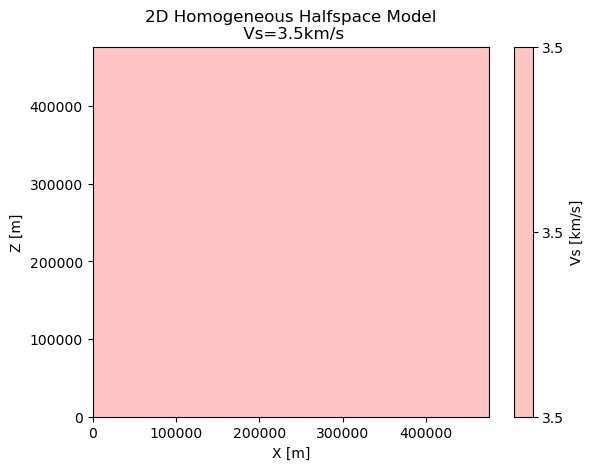

In [6]:
def plot_homogeneous_halfspace():
    """
    Plots a representation of the SPECFEM2D 
    homogeneous halfspace model
    """
    # Sets the X and Z dimensions of our mesh
    x = np.arange(0, 480000, 4000)
    z = np.arange(0, 480000, 4000)
    
    # Reformat the 1D arrays into 2D
    xv, zv = np.meshgrid(x, z)

    # Set a homogeneous value of Vs=3.5km/s 
    vs = 3.5 * np.ones(np.shape(xv))

    # Plot the arrays as a homogeneous halfspace
    plt.tricontourf(xv.flatten(), zv.flatten(), vs.flatten(), 
                    cmap="seismic_r", vmin=3.1, vmax=4.)
    plt.colorbar(label="Vs [km/s]", format="%.1f")
    plt.xlabel("X [m]")
    plt.ylabel("Z [m]")
    plt.title("2D Homogeneous Halfspace Model\n Vs=3.5km/s")
    
# Calls the function we just defined
plot_homogeneous_halfspace()

### b) Perturbation Checkerboard Model

- The checkerboard model features smoothly varying 2D Gaussians which perturbs the homogeneous halfspace model ($V_s$ and $V_p$) by roughly $\pm$10%  
- The checkerboard model is defined by an **external** velocity model file: *DATA/model_velocity.dat_checker*
- SPECFEM can read external files of various formats to define the velocity model. 
- **SPECFEM3D NOTE**: In SPECFEM3D we typically use [external tomography files (.xyz)](https://specfem3d.readthedocs.io/en/latest/13_changing_the_model/#using-external-tomographic-earth-models) which defines coordinates (X, Y, Z) and material properties (e.g., Vp, Vs, rho, Q)
- The following checkerboard model file similarly defines coordinates and material properties    

The columns of the checkerboard model are defined: 
```bash
line_number x[m] z[m] density vp[m/s] vs[m/s]
```

In [7]:
# Look at the first few lines of the checkerboard model
! head DATA/model_velocity.dat_checker

	0	    0.0000	    0.0000	2600.0000	5800.0000	3500.0000
	1	 2072.1000	    0.0000	2600.0000	5800.0000	3500.0000
	2	 6000.0000	    0.0000	2600.0000	5800.0000	3500.0000
	3	 9927.9000	    0.0000	2600.0000	5800.0000	3500.0000
	4	12000.0000	    0.0000	2600.0000	5800.0000	3500.0000
	5	    0.0000	 2072.1000	2600.0000	5800.0000	3500.0000
	6	 2072.1000	 2072.1000	2600.0000	5800.3000	3500.3000
	7	 6000.0000	 2072.1000	2600.0000	5800.8000	3501.0000
	8	 9927.9000	 2072.1000	2600.0000	5801.3000	3501.6000
	9	12000.0000	 2072.1000	2600.0000	5801.6000	3501.9000


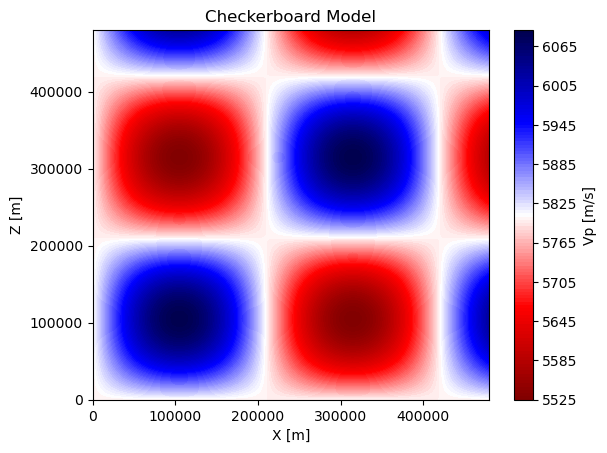

In [30]:
# Grab values of X, Z, Vs and Vp for plotting
chkbd_x, chkbd_z, chkbd_vp, chkbd_vs = np.genfromtxt("DATA/model_velocity.dat_checker", dtype=float, usecols=[1,2,4,5]).T

def plot_checkerboard(x, z, c, label, alpha=1):
    """Simple re-usable model plotting function"""
    plt.tricontourf(x, z, c, levels=125, cmap="seismic_r", alpha=alpha)
    plt.xlabel("X [m]")
    plt.ylabel("Z [m]")
    plt.title("Checkerboard Model")
    plt.colorbar(label=label)
    
plot_checkerboard(chkbd_x, chkbd_z, chkbd_vp, label="Vp [m/s]")

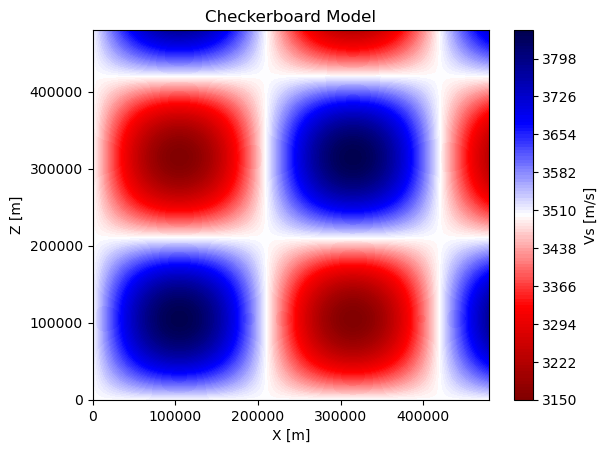

In [22]:
plot_checkerboard(chkbd_x, chkbd_z, chkbd_vs, label="Vs [m/s]")

#### Understanding the checkerboard
- The mean (perturbed) velocity is equal to the homogeneous halfspace counterpart  
- **red/warm** colors equal *relatively* **slow** velocities
- **blue/cold** colors equal *relatively* **fast** velocities
- This is the typical color convention scheme used in seismic imaging

### c) Visualizing Source-Receiver Geometry

- It's useful to plot SOURCES and STATIONS with respect to the checkerboard model  
- These figures can give us some idea of how the underlying model will affect the resulting synthetics 
- These data grabbing / plotting functions are the same as Day 1  

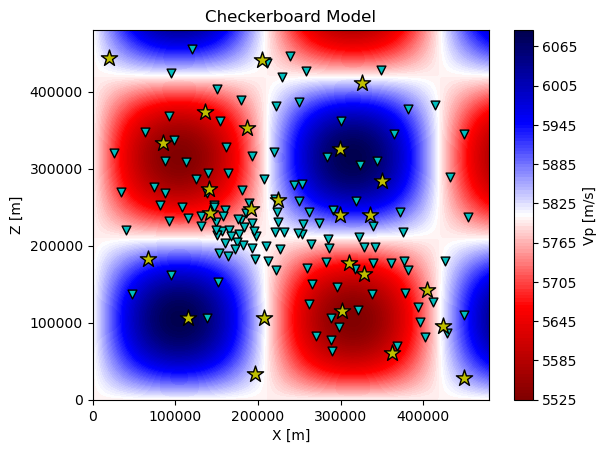

In [32]:
# Grab coordinates from STATIONS file
sta_x, sta_z = np.genfromtxt("DATA/STATIONS_checker", dtype=float, usecols=[2, 3]).T

# Grab coordinates from SOURCE files
ev_x, ev_z = [], []
for i in range(1, 26):
    source_file = f"DATA/SOURCE_{i:0>3}"
    with open(source_file, "r") as f:
        lines = f.readlines()
    # Trying to break apart the following line
    # 'xs = 299367.72      # source location x in meters\n'
    xs = float(lines[2].split("=")[1].split("#")[0].strip())
    zs = float(lines[3].split("=")[1].split("#")[0].strip())
    
    ev_x.append(xs)
    ev_z.append(zs)
    
# Plot SOURCES and STATIONS on top of the checkerboard model
plot_checkerboard(chkbd_x, chkbd_z, chkbd_vp, label="Vp [m/s]")
plt.scatter(sta_x, sta_z, c="c", marker="v", s=40, edgecolor="k")
plt.scatter(ev_x, ev_z, c="y", marker="*", s=150, edgecolor="k")

Text(0.5, 1.0, 'SOURCES; N=25')

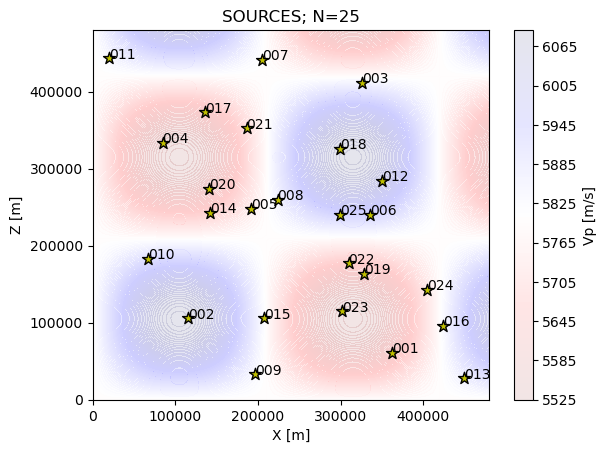

In [34]:
# Plot SOURCES next to source names
plot_checkerboard(chkbd_x, chkbd_z, chkbd_vp, label="Vp [m/s]", alpha=0.1)

for i, (x, z) in enumerate(zip(ev_x, ev_z)):
    plt.scatter(x, z, c="y", marker="*", edgecolor="k", s=80)
    plt.text(x, z, f"{i+1:0>3}", c="k")  # SOURCE numbering starts at 1
plt.title(f"SOURCES; N={len(ev_x)}")

Text(0.5, 1.0, 'STATIONS; N=132')

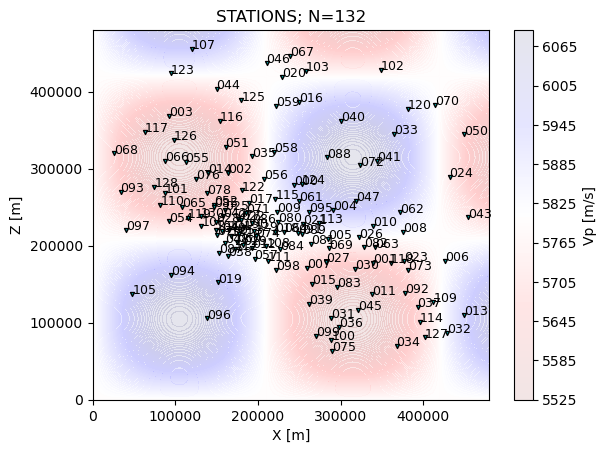

In [36]:
# Plot STATIONS next to source names
plot_checkerboard(chkbd_x, chkbd_z, chkbd_vp, label="Vp [m/s]", alpha=0.1)

for i, (x, z) in enumerate(zip(sta_x, sta_z)):
    plt.scatter(x, z, c="c", marker="v", s=8, edgecolor="k")
    plt.text(x, z, f"{i:0>3}", fontsize=9)
plt.title(f"STATIONS; N={len(sta_x)}")

Text(0.5, 1.0, 'SOURCE 01; STATION 01')

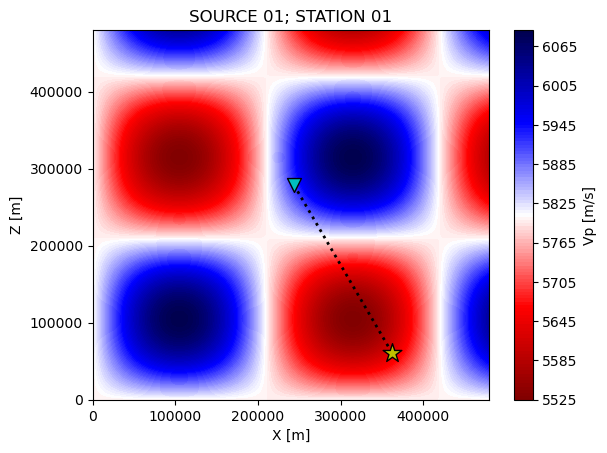

In [62]:
# Plot the experimental setup we'll use for Section 2
plot_checkerboard(chkbd_x, chkbd_z, chkbd_vp, label="Vp [m/s]")

# Plot SOURCE 1, STATION 1 and a connecting line
plt.plot((sta_x[0], ev_x[0]), (sta_z[0], ev_z[0]), c="k", ls=":", lw=2, zorder=1)
plt.scatter(sta_x[0], sta_z[0], c="c", marker="v", s=100, edgecolor="k")
plt.scatter(ev_x[0], ev_z[0], c="y", marker="*", edgecolor="k", s=200)

plt.title(f"SOURCE 01; STATION 01")

#### Understanding Source-Receiver Figures

- Upside-down blue triangles represent 132 receivers/stations  
- Yellow stars represent 25 sources/events  
- Red colors in the checkerboard model represent relatively **slow** velocities 
- Blue colors in the checkerboard model represent relatively **fast** velocities  


---------------
## 2) Setting up an Adjoint Simulation

- In this section we will learn how to set SPECFEM for an adjoint simulation  
- We will need to generate adjoint sources (defined below)  
- We will also need to make some `Par_file` edits

#### Useful Definitions
- `Adjoint simulation`: simulates the interaction of a forward and adjoint wavefield
- `Forward wavefield`: the seismic wavefield propagated from the source location
- `Adjoint wavefield`: a wavefield that propagates from receiver locations, whos time-dependent amplitude is controlled by adjoint sources
- `Adjoint source`: time-reversed waveforms input at receiver locations. Typically they contain information about the forward wavefield (sensitivity kernels), or data-synthetic misfit (misfit kernel)  
- `Kernel`: The volumetric integration of the interaction between the forward and adjoint wavefields, highlighting regions/parameters of the model that have an effect on the wavefield or misfit  

#### Useful Information
- SPECFEM saves the forward wavefield and propagates it **backwards in time**  
- Adjoint wavefield propagates adjoint sources from each receiver simultaneously (i.e., **1** adjoint simulation per event)
- Each component of each receiver therefore is capable of generating an adjoint source  
- Adjoint sources can be selectively windowed to isolate certain parts of the synthetic seismogram  

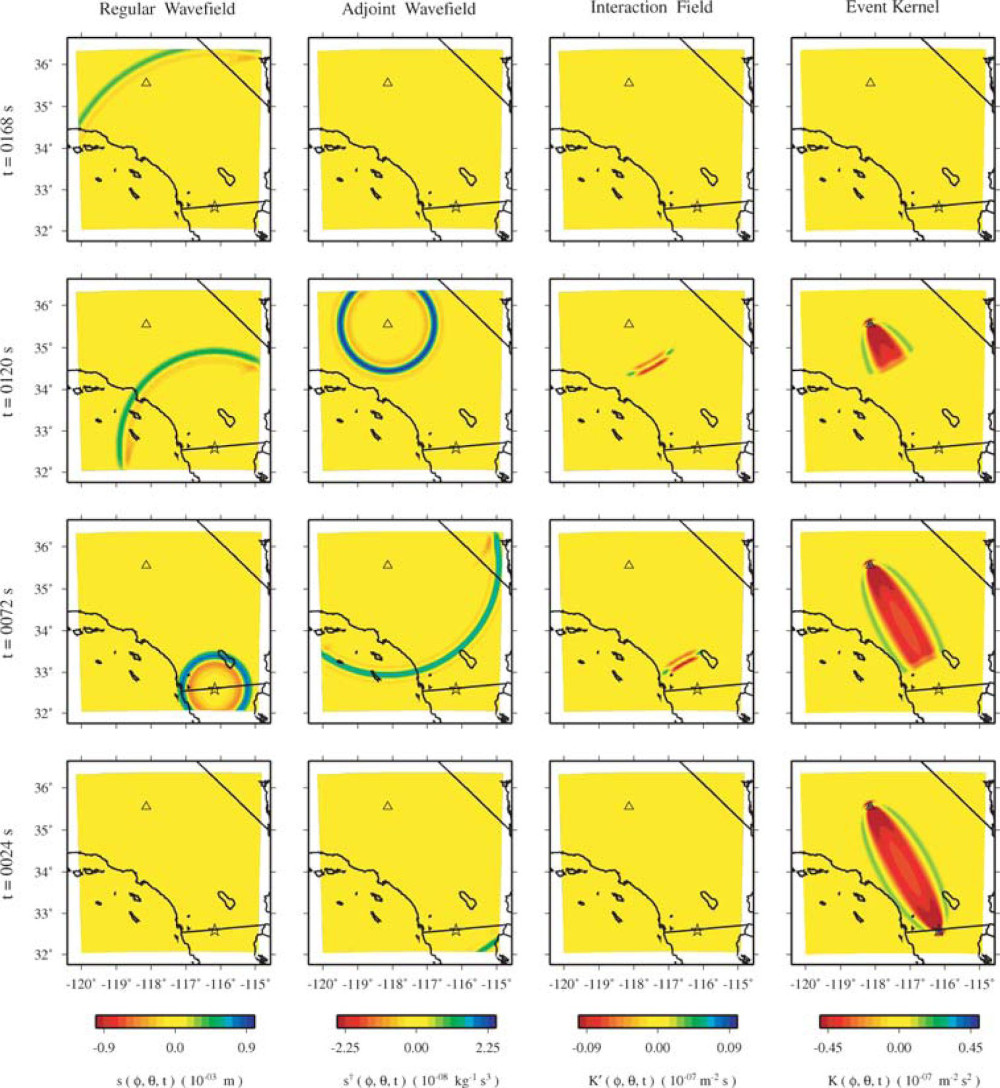

**[Tape et al. 2007 Figure 5:](https://academic.oup.com/view-large/figure/31726676/168-3-1105-fig005.jpeg)** *Sequence of interactions between the regular and adjoint wavefields during the construction of a traveltime cross‐correlation event kernel K(x). The ⋆ symbol denotes the source, and the Δ symbol denotes the receiver. Each row represents the time‐step indicated on the left... The event kernel shows the region of the current model that gives rise to the discrepancy between the data and the synthetics.*

In [37]:
%cd /home/scoped/work/day_2/specfem2d_workdir

/home/scoped/work/day_2/specfem2d_workdir


### a) Generating 'Data' with a Target Model

- **Objective:** Generate synthetic seismogram using checkerboard model
- In the context of seismic imaging, adjoint sources are proportional to data-synthetic misfit  
- We use the checkerboard model shown above as a `True` or `Target` 
- `Target` model is used to generate synthetic waveforms that are meant to approximate real world data. 
- In a real seismic inversion, data are actual waveforms recorded during a seismic event  
- We will choose a single source and a single receiver to generate our misfit kernel  

In [44]:
# We use SOURCE 1 as our preferred event
! cp -f DATA/SOURCE_001 DATA/SOURCE

# We take the first line of the STATIONS file as our single station
! head -1 DATA/STATIONS_checker > DATA/STATIONS

# Copy the Parameter file and make some adjustments 
! cp -f DATA/Par_file_Tape2007_132rec_checker DATA/Par_file

# Set parameters 
! seisflows sempar -P DATA/Par_file NSTEP 5000  # to match homogeneous halfspace Par_file
! seisflows sempar -P DATA/Par_file save_model binary
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1

# Ensure that SPECFEM can find the checkerboard model by naming it correctly
! cp -f DATA/model_velocity.dat_checker DATA/proc000000_model_velocity.dat_input

# Run Meshfem and SPECFEM SPECFEM2D 
! mpirun -n 1 bin/xmeshfem2D > OUTPUT_FILES/output_mesher.txt
! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

# Rename the OUTPUT_FILES so that our next run doesn't overwrite files
! mv OUTPUT_FILES OUTPUT_FILES_TRUE

# Print the log message when the simulation is finished
! tail OUTPUT_FILES_TRUE/output_solver.txt

NSTEP: 4800 -> 5000
SAVE_MODEL: default -> binary
setup_with_binary_database: 0 -> 1
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Tape-Liu-Tromp (GJI 2007)
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 02 - 10 - 2022                                 T i m e  : 19:14:26
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------


#### Parameter changes explained
- `NSTEP` (number of time steps) is increased to 5000 to set synthetic waveform length  
- `save_model` is set to binary so that SPECFEM outputs FORTRAN binary files defining the model  
- `setup_with_binary_database` tells SPECFEM to write DATABASE files rather than discarding them  

>__MPI NOTE__: We ran this simulation in serial (`NPROC`==1). If you wanted to this simulation in parallel (`NPROC`>1) you would also need to manually partition the checkerboard model (model_velocity.dat_checker -> proc000???_model_velocity.dat_input). This is a unique caveat of SPECFEM2D's Legacy input model type. Those using external tomography models (.xyz files) will **not** face this requirement.

OUTPUT_FILES_TRUE/AA.S000000.BXY.semd


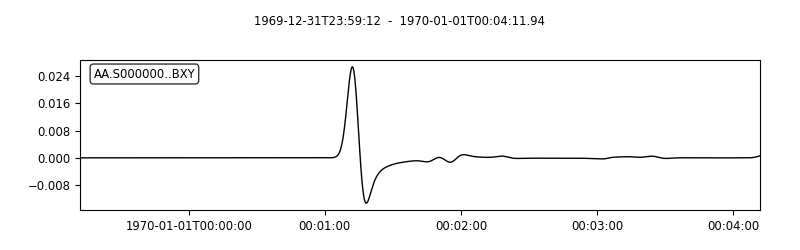

In [49]:
# SPECFEM has generated one synthetic seismogram
! ls OUTPUT_FILES_TRUE/*semd

# We can look at this 'data' waveform using SeisFlows plot
! seisflows plotst OUTPUT_FILES_TRUE/AA.S000000.BXY.semd --savefig AA.S000000.BXY.png
Image("AA.S000000.BXY.png")

### b) Generating Synthetics using Initial Model

- **Objective:** generate synthetic waveforms using the homogeneous halfspace model. 
- In this example we will use the homogeneous halfspace model as our `starting` or `initial` model  
- We use the **same** source and receivers as the Target model, to ensure that we can compare the waveforms generated  
- We expect that the waveform generated by the `Target` and `Initial` models will **differ**  

In [123]:
# The SOURCE and STATIONS files should remain the same,
# we only want to tell SPECFEM to use the homogeneous halfspace model
! cp -f DATA/Par_file_Tape2007_onerec DATA/Par_file

# Set some Par_file parameters to match the previous run
! seisflows sempar -P DATA/Par_file use_existing_stations .true.
! seisflows sempar -P DATA/Par_file save_model binary
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1
! seisflows sempar -P DATA/Par_file save_forward .true.

# Run SPECFEM with the homogeneous halfspace model, defined in the Par_file
! rm -r OUTPUT_FILES
! mkdir OUTPUT_FILES
! mpirun -n 1 bin/xmeshfem2D > OUTPUT_FILES/output_mesher.txt
! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

# Copy the OUTPUT_FILES so that our subsequent run doesn't overwrite files
# We do this because the adjoint simulation will require DATABASE files located within
! cp -r OUTPUT_FILES OUTPUT_FILES_INIT

# Print the log message when the simulation is finished
! tail OUTPUT_FILES_INIT/output_solver.txt

use_existing_STATIONS: .false. -> .true.
SAVE_MODEL: default -> binary
setup_with_binary_database: 0 -> 1
SAVE_FORWARD: .false. -> .true.
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Tape-Liu-Tromp (GJI 2007)
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 02 - 10 - 2022                                 T i m e  : 19:28:54
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------


#### Parameter changes explained

- The parameters we have changed are the same as in Subsection (a)
- The new `save_forward` parameter tells SPECFEM to save a snapshot of the last frame of the wavefield  
- This snapshot is used to back-construct the forward wavefield during an adjoint simulation

In [74]:
# Look at the resulting outputs of the `save_forward` parameter
! diff -qr OUTPUT_FILES_INIT/ OUTPUT_FILES_TRUE/ | grep 'Only'

Only in OUTPUT_FILES_INIT/: absorb_elastic_bottom000000.bin
Only in OUTPUT_FILES_INIT/: absorb_elastic_left000000.bin
Only in OUTPUT_FILES_INIT/: absorb_elastic_right000000.bin
Only in OUTPUT_FILES_INIT/: absorb_elastic_top000000.bin
Only in OUTPUT_FILES_INIT/: lastframe_elastic000000.bin


OUTPUT_FILES_INIT/AA.S000000.BXY.semd


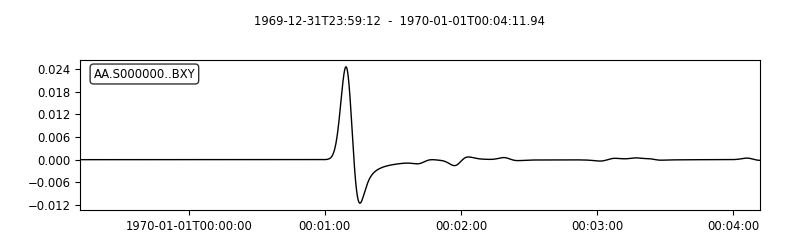

In [76]:
# Again we can look at the waveform. We will compare in the next section
! ls OUTPUT_FILES_INIT/*semd

! seisflows plotst OUTPUT_FILES_INIT/AA.S000000.BXY.semd --savefig AA.S000000.BXY.png
Image("AA.S000000.BXY.png")

### c) Misfit Quantification and Adjoint Sources

- We use the term `misfit` to define differences between data and synthetics
- Misfit can be defined based on a number of factors such as: phase, amplitude, or waveform differences
- Adjoint sources are waveforms proportional to the time-dependent misfit
- The chosen misfit function directly influences adjoint simulations and seismic imaging studies by extension  

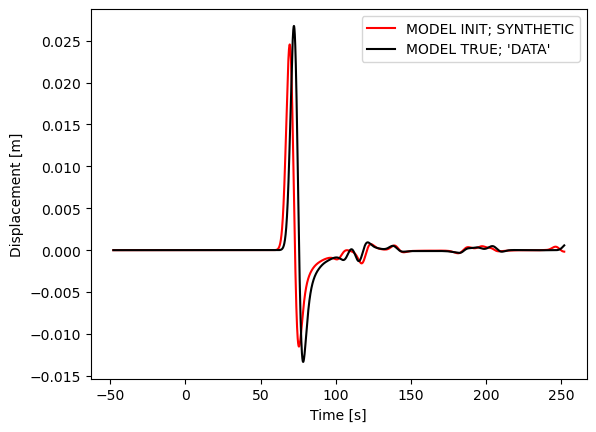

In [77]:
# Read in the two-column ASCII files using NumPy where - t=time; d=data
t_init, d_init = np.loadtxt("OUTPUT_FILES_INIT/AA.S000000.BXY.semd").T
t_true, d_true = np.loadtxt("OUTPUT_FILES_TRUE/AA.S000000.BXY.semd").T

# Plot both waveforms using Matplotlib
plt.plot(t_init, d_init, c="r", label="MODEL INIT; SYNTHETIC")
plt.plot(t_true, d_true, c="k", label="MODEL TRUE; 'DATA'")
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.legend()
plt.show()

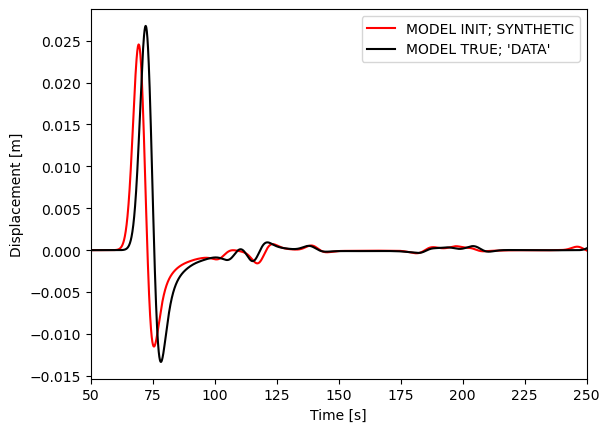

In [82]:
# Zoom in on waveform figure ignoring T<50s
plt.plot(t_init, d_init, c="r", label="MODEL INIT; SYNTHETIC")
plt.plot(t_true, d_true, c="k", label="MODEL TRUE; 'DATA'")
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.xlim((50,250))
plt.legend()
plt.show()

#### Comments on Default Waveform Figure

- `TRUE` (red) synthetic shows a phase delay (negative time shift) with respect to the `INIT` synthetic (black)  
- This reflects that longer relative path length in the red/slow potion of the checkerboard  

## 3) Misfit Quantification

- **Objective**: Quantify the misfit between data and synthetic and generate adjoint source using Python and showing alternatives with Pyatoa
- Misfit function will be defined by waveform misfit (also known as objective function)
- Adjoint source defines the gradient of the misfit function
- *Acknowledging that some of this section is modified from Ridvan Orsvuran's [Jupyter Notebook](https://github.com/rdno/simple_2d_kernel/blob/main/Simple_Specfem2D_Kernel.ipynb)*  


### a) Misfit Calculation with Python
- Waveform misfit function: $ \chi = \frac{1}{2} \int [d(t)-s(t)]^2 dt~$  
    - d(t): time-dependent 'data' waveform (black trace Section 2c)
    - s(t): time-dependent 'synthetic' waveform (red trace Section 2c).
- In Python we will perform the integration step using using [Simpson's rule](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.simps.html).

In [83]:
# Integrate using scipy
dt = t_true[1] - t_true[0]  # dt represents the time step
misfit = 1/2 * simps((d_true - d_init)**2, dx=dt)

print(f"misfit={misfit:.3E}")

misfit=1.453E-03


### b) Adjoint Source with Python

- The adjoint source is a time-dependent measure of misfit  
- It is defined as the **gradient** of the misfit function  
- Waveform adjoint source: $f^\dagger (t) = s(t) - d(t)$


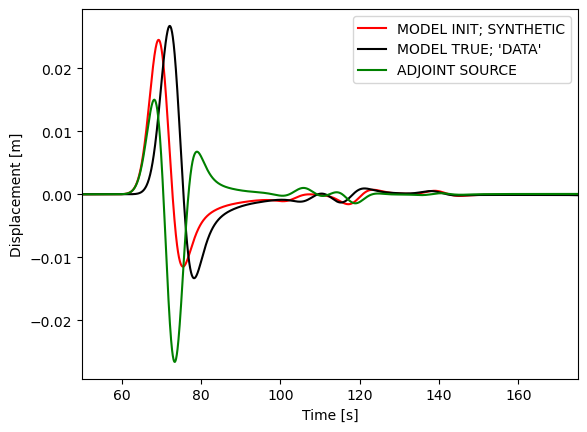

In [118]:
# Calculate the adjoint source using data and synthetic
d_adj = d_init - d_true

# Plot both waveforms using Matplotlib
plt.plot(t_init, d_init, c="r", label="MODEL INIT; SYNTHETIC")
plt.plot(t_true, d_true, c="k", label="MODEL TRUE; 'DATA'")
plt.plot(t_init, d_adj, c="g", label="ADJOINT SOURCE")
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.xlim([50, 175])
plt.legend()
plt.show()

#### Understanding the waveform adjoint source figure  
- We can see that the adjoint source is equal to 0 when the waveforms are the same and peaks when the waveforms are the most different  
- In this case we only have one component of an adjoint source (Y)
- The adjoint source will be fed in at receiver locations during an adjoint simulation  
- The resulting adjoint wavefield interacts with the forward wavefield to illuminate parts of the model that the misfit function is sensitive to  

### c) Adjoint Source with Pyatoa
- [Pyatoa](https://github.com/adjtomo/pyatoa) (*Python's Adjoint Tomography Operations Assistant*) is a Python-based misfit quantification tool
- It contains a number of misfit and adjoint source types
- It generates waveform figures and utilities for facilitating adjoint source creation

[2022-10-02 20:09:18] - pyatoa - WARNING: No origintime given, setting to default 1970-01-01T00:00:00
[2022-10-02 20:09:18] - pyatoa - WARNING: No origintime given, setting to default 1970-01-01T00:00:00
[2022-10-02 20:09:18] - pyatoa - INFO: standardizing streams
[2022-10-02 20:09:18] - pyatoa - DEBUG: start and endtimes already match to 0.001
[2022-10-02 20:09:18] - pyatoa - INFO: preprocessing observation data
[2022-10-02 20:09:18] - pyatoa - WARNING: taper amount exceeds time offset, taper may affect data if source receiver distance is short
[2022-10-02 20:09:18] - pyatoa - INFO: Manager has no inventory attribute, will not remove response
[2022-10-02 20:09:18] - pyatoa - INFO: skip remove response: no inventory or requested not to
[2022-10-02 20:09:18] - pyatoa - DEBUG: bandpass filter: 1.0 - 100.0s w/ 2.0 corners
[2022-10-02 20:09:18] - pyatoa - INFO: preprocessing synthetic data
[2022-10-02 20:09:18] - pyatoa - WARNING: taper amount exceeds time offset, taper may affect data if 

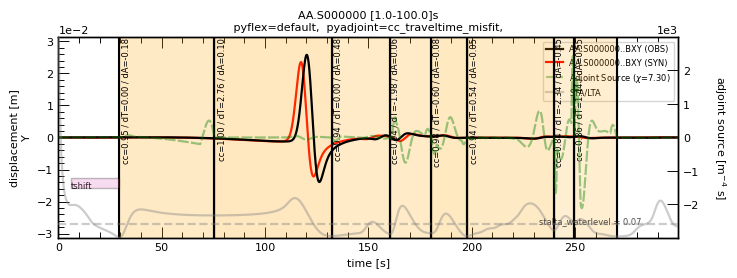

In [112]:
# Pyatoa has a verbose logger that describes underlying workflow 
logger.setLevel("DEBUG")

# All user-defined parameters are defined in a Config class
config = Config(min_period=1, max_period=100, adj_src_type="cc", 
                component_list=["Y"], start_pad=48)

# Read in synthetics as ObsPy streams
st_obs = read_sem("OUTPUT_FILES_TRUE/AA.S000000.BXY.semd")
st_syn = read_sem("OUTPUT_FILES_INIT/AA.S000000.BXY.semd")

# Instantiate a manager, which runs the Pyatoa misfit quantification step
mgmt = Manager(config=config, st_obs=st_obs, st_syn=st_syn)
mgmt.flow()  # shorthand convenience function

# Create a waveform plot and output adjoint source
mgmt.plot(save="pyatoa_misfit.png", choice="wav")
mgmt.write_adjsrcs()

In [116]:
hasattr(st_syn[0].stats, "time_offset")

True

In [113]:
# Pyatoa has written the adjoint source SPECFEM-ready 
! ls *.adj
! echo
! head AA.S000000.BXY.adj
! rm AA.S000000.BXY.adj  # remove because we'll use the Python-derived adjsrc instead

AA.S000000.BXY.adj

0.000000000000000000e+00 0.000000000000000000e+00
5.999999999999999778e-02 0.000000000000000000e+00
1.199999999999999956e-01 0.000000000000000000e+00
1.799999999999999933e-01 0.000000000000000000e+00
2.399999999999999911e-01 0.000000000000000000e+00
2.999999999999999889e-01 0.000000000000000000e+00
3.599999999999999867e-01 0.000000000000000000e+00
4.199999999999999845e-01 0.000000000000000000e+00
4.799999999999999822e-01 0.000000000000000000e+00
5.400000000000000355e-01 0.000000000000000000e+00


#### Understanding the Pyatoa waveform figure
- The black trace is 'data', the red trace is synthetic, green trace is adjoint source
- Orange boxes represent misfit windows which separate the synthetic based on phase
- The coverage, length and frequency of windows can be controlled in Pyflex
- Misfit is labelled in the legend as $\chi$

-----------

## 3) Running an Adjoint Simulation
- To run an adjoint simulation in SPECFEM2D, we need to make a few changes to the parameter file
- We will use our Python-derived adjoint source, which needs to be placed in a directory locateable by SPECFEM 
- **COMPONENT NOTE:** SPECFEM expects adjoint sources for **ALL** components, even if they do not have adjoint sources. These should just be waveforms with amplitude 0  
- **SPECFEM3D NOTE:** SPECFEM3D also requires a *DATA/STATIONS_ADJOINT* file, which defines stations that have corresponding adjoint sources. 


In [102]:
%cd /home/scoped/work/day_2/specfem2d_workdir

/home/scoped/work/day_2/specfem2d_workdir


### a) Writing Adjoint Sources

**IMPORTANT:** SPECFEM expects adjoint sources in a directory called `SEM/` with a specific format and filename

- Adjoint sources should be defined in the same way that the synthetics have been created. 
- In this case that means two-column ASCII files where the time axis exactly matches the the synthetic outputs. 
- Filename must also match synthetics, but with a `.adj` suffix; i.e., for synthetic `AA.S000000.BXY.semd`, corresponding adjoint source is: `AA.S000000.BXY.adj`.
- We can use Python to write this out in the correct location.

In [119]:
# Make the requisite SEM/ directory
! mkdir SEM/

# Generate the two-column (time, data) format required
adjoint_source = np.vstack((t_init, d_adj)).T

# Save the .adj file as an ASCII file
np.savetxt("SEM/AA.S000000.BXY.adj", adjoint_source)
! head SEM/AA.S000000.BXY.adj

-4.800000000000000000e+01 0.000000000000000000e+00
-4.793999999999999773e+01 0.000000000000000000e+00
-4.788000000000000256e+01 0.000000000000000000e+00
-4.782000000000000028e+01 0.000000000000000000e+00
-4.775999999999999801e+01 0.000000000000000000e+00
-4.770000000000000284e+01 0.000000000000000000e+00
-4.764000000000000057e+01 0.000000000000000000e+00
-4.757999999999999829e+01 0.000000000000000000e+00
-4.752000000000000313e+01 0.000000000000000000e+00
-4.746000000000000085e+01 0.000000000000000000e+00


### b) Run `xspecfem2D`

- Now that we have the required setup in the `Par_file`, and the `SEM/` directory with the `.adj` adjoint source files, we can run the solver `xspecfem2D`  
- We do **not** need to re-run the mesher as the adjoint simulations will run on the **same** numerical mesh that we used for our solver  

#### Parameter file changes
`simulation_type`: Simulation type 3 tells SPECFEM that we are running an adjoint simulation  
`save_ASCII_kernels`: Tells SPECFEM to save the resulting misfit kernel in binary format (not ASCII)

In [125]:
# Set the parameter file for an adjoint simulation
! seisflows sempar -P DATA/Par_file simulation_type 3
! seisflows sempar -P DATA/Par_file save_ASCII_kernels .false.

! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/output_adjsolver.txt

# The adjoint solver also produces an informative log file
! tail OUTPUT_FILES/output_adjsolver.txt

# We can check this was an adjoint simulation because SPECFEM considers adjoint sources
! echo
! head -338 OUTPUT_FILES/output_adjsolver.txt | tail -n 5

SIMULATION_TYPE: 1 -> 3
save_ASCII_kernels: .true. -> .false.
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Tape-Liu-Tromp (GJI 2007)
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 02 - 10 - 2022                                 T i m e  : 20:33:06
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------

 adjoint sources:
   adjoint source type:           1
   reading ASCII adjoint source files
   number of adjoint sources =            1
   adjoint sources min/max   =   -2.66350228E-02   1.50289452E-02


### c) Understanding Adjoint Simulation Outputs

- Adjoint simulations generate kernel files in the same format as the Databases and model files
- Kernels are generated for each quantity that defines the model

#### Event Kernel

- The most important output of the adjoint simulation is the event kernel  
- These files are named something like `proc*_alpha_kernel.bin` (here alpha==Vp)  
- Kernels define the volumentric integration of the interaction between the forward and adjoint wavefields   
- We'll rename these kernels to make them more intutive (alpha $\rightarrow V_p$; beta $\rightarrow V_s$)  

In [131]:
# Copy over the Model files so SeisFlows has access to coordinate information
! cp -r DATA/*.bin OUTPUT_FILES

# Rename alpha and beta kernels
! cp OUTPUT_FILES/proc000000_alpha_kernel.bin OUTPUT_FILES/proc000000_vp_kernel.bin 
! cp OUTPUT_FILES/proc000000_beta_kernel.bin OUTPUT_FILES/proc000000_vs_kernel.bin 

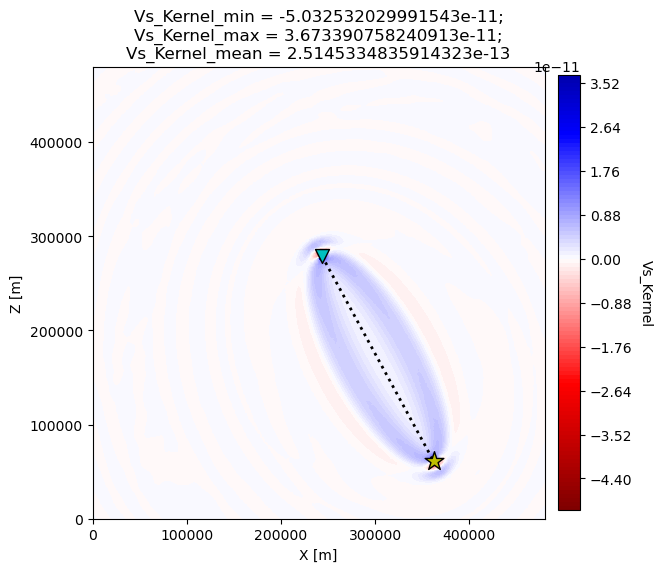

In [132]:
# Use SeisFlows to visualize the kernel
m = Model(path="OUTPUT_FILES")
m.plot2d("vs_kernel", show=False)

# NOTE: The below code snippet is repeated from Section 1, make sure that has been run
# Plot SOURCE 1, STATION 1 and a connecting line
plt.plot((sta_x[0], ev_x[0]), (sta_z[0], ev_z[0]), c="k", ls=":", lw=2, zorder=1)
plt.scatter(sta_x[0], sta_z[0], c="c", marker="v", s=100, edgecolor="k")
plt.scatter(ev_x[0], ev_z[0], c="y", marker="*", edgecolor="k", s=200)

#### Understanding the event kernel
- Constructed via the interaction between the forward wavefield and the adjoint wavefield  
- Illuminates sections of the model that the objective function is sensitive to
- Note that the direct ray path (dotted line) has almost zero sensitivity (white)
- The kernel is 'fat', meaninng sensitivity extends a finite width away from the direct raypath  
- Generated by a single source-receiver pair here, but in larger adjoint simulations, will combine many adjoint sources


#### SPECFEM2D Adjoint Images

- SPECFEM2D also produces adjoint images which document the adjoint wavefield  
- These do not show the interaction, but rather adjoint source emanating from the receiver location (i.e. column 2 in Tape et al. Fig 5)  

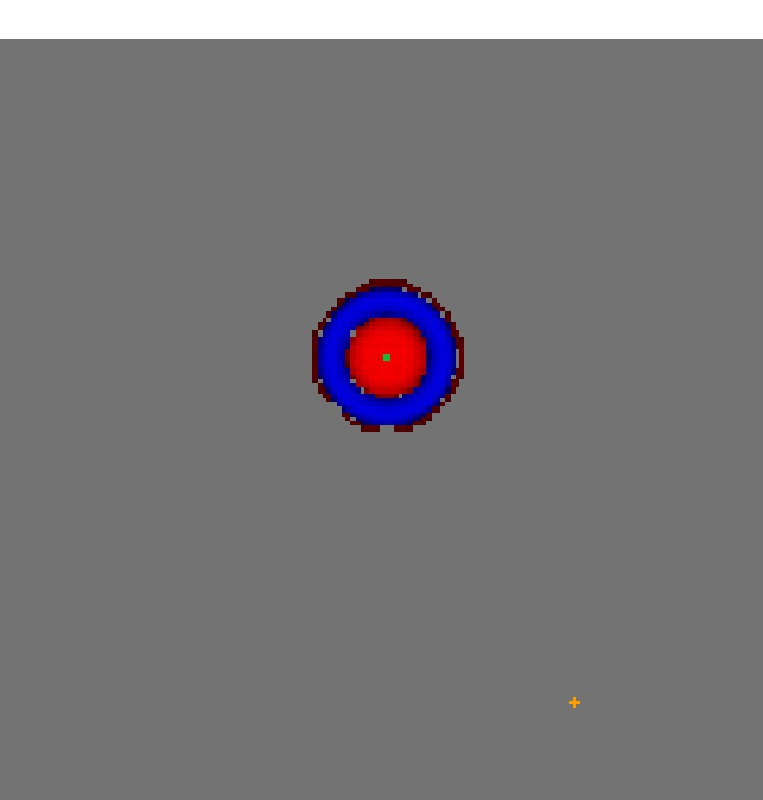

In [133]:
Image("OUTPUT_FILES/adjoint_image000000200.jpg")

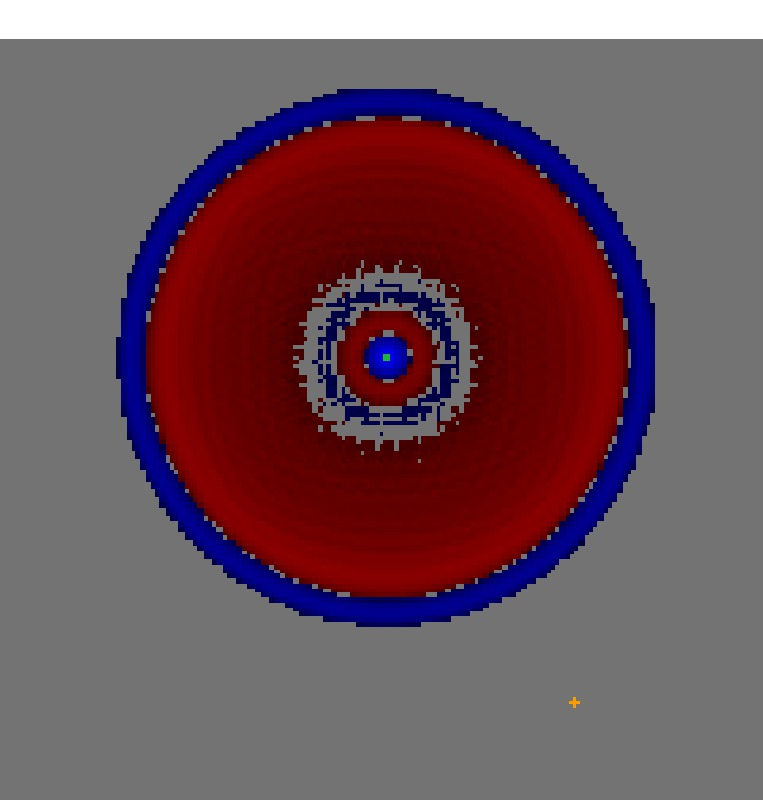

In [134]:
Image("OUTPUT_FILES/adjoint_image000000800.jpg")

----------
## 4) Smoothing/Regularizing Kernels

- The kernel above is *complicated*, lots of fringes seen away from the actual kernel  
- Regularization is a process that changes results to be *simpler*  
- There are many instances in which you might want to regularize a kernel:
    - If your data is band-limited, you may know that you don't have sensitivity to small-scale perturbations, which we can remove to get at large-scale structure
    - Due to numerical discretization, areas around the source and receiver will have very large-amplitude, high-frequency kernels that are not realistic  
    - Smooth away these small-scale perturbations to get at large-scale structure
    
    
In SPECFEM we can smooth kernels as a form of regularization
- We use the SPECFEM executable `xsmooth_sem` to convolve our kernel with a 2D Gaussian
- We choose the X and Z half-widths of this Gaussian

In [135]:
# In order to smooth waveforms, we use `xsmooth_sem`. If we run without arguments, we get the USAGE
! mpirun -n 1 bin/xsmooth_sem

 Running XSMOOTH_SEM on           1 processors
 USAGE:  mpirun -np NPROC bin/xsmooth_sem SIGMA_H SIGMA_V KERNEL_NAME INPUT_DIR OUPUT_DIR GPU_MODE
  Please check command line arguments
 Error detected, aborting MPI... proc            0
Abort(30) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 30) - process 0


 The usage of `xsmooth_sem` is given as
 ```bash
 USAGE:  mpirun -np NPROC bin/xsmooth_sem SIGMA_H SIGMA_V KERNEL_NAME INPUT_DIR OUPUT_DIR GPU_MODE
 ```
 We will need to choose values and directories to make this work
  - `SIGMA_H`: Horizontal smoothing length [m] representing the horizontal half-width of the Gaussian  
  - `SIGMA_Z`: Vertical smoothing length [m] representing the vertical half-width of the Gaussian  
  - `KERNEL_NAME`: The name of the kernel we want to smooth. Must match filename, so `proc000000_vs_kernel.bin` corresponds to a matching kernel name: `vs_kernel`  
  - `INPUT_DIR`: where SPECFEM can find the kernel files
  - `OUTPUT_DIR`: Where SPECFEM should output the SMOOTHED kernels 
  - `GPU_MODE`: Use GPU acceleration to speed up the smoothing operation (.true. or .false.)

 Running XSMOOTH_SEM on           1 processors
 command line arguments:
   smoothing sigma_h , sigma_v                :    5000.00000       5000.00000    
   smoothing scalelengths horizontal, vertical:    14142.1357       14142.1357    
   input dir : OUTPUT_FILES/
   output dir: OUTPUT_FILES/


 Scaling values: min/max =    39263216.0       157106752.    
 written: OUTPUT_FILES//proc000000_vs_kernel_smooth.bin

  Min / Max data value before smoothing =    4.77881162E-19   6.47305820E-12 for vs_kernel
  Min / Max data value after smoothing  =    1.25300957E-19   5.14250318E-12 for vs_kernel
 Computation time with CPU:   16.8872166    
OUTPUT_FILES/proc000000_alpha_kernel.bin
OUTPUT_FILES/proc000000_beta_kernel.bin
OUTPUT_FILES/proc000000_bulk_beta_kernel.bin
OUTPUT_FILES/proc000000_bulk_c_kernel.bin
OUTPUT_FILES/proc000000_kappa_kernel.bin
OUTPUT_FILES/proc000000_mu_kernel.bin
OUTPUT_FILES/proc000000_rho_kernel.bin
OUTPUT_FILES/proc000000_rhop_kernel.bin
OUTPUT_FILES/proc000000_vp_ker

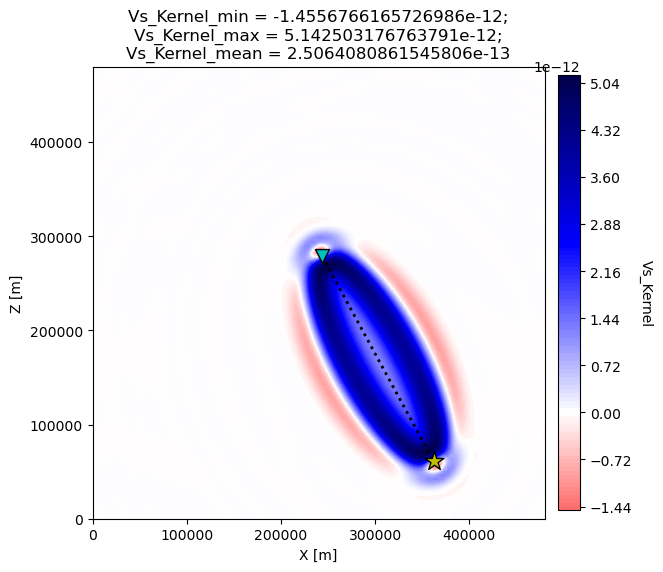

In [137]:
# Run the smoothinig operation
! mpirun -n 1 bin/xsmooth_sem 5000 5000 vs_kernel OUTPUT_FILES/ OUTPUT_FILES/ .false.

# Smoothed kernels are renamed <KERNEL_NAMEL>_smooth
! ls OUTPUT_FILES/*kernel*.bin

# Rename kernel files so we can plot the smooth version with SeisFlows
! mv OUTPUT_FILES/proc000000_vs_kernel.bin OUTPUT_FILES/proc000000_vs_kernel_raw.bin
! mv OUTPUT_FILES/proc000000_vs_kernel_smooth.bin OUTPUT_FILES/proc000000_vs_kernel.bin

# Use SeisFlows to visualize the kernel
m = Model("OUTPUT_FILES")
m.plot2d("vs_kernel", show=False)

# Plot source and receiver on the kernel figure
plt.plot((sta_x[0], ev_x[0]), (sta_z[0], ev_z[0]), c="k", ls=":", lw=2, zorder=1)
plt.scatter(sta_x[0], sta_z[0], c="c", marker="v", s=100, edgecolor="k")
plt.scatter(ev_x[0], ev_z[0], c="y", marker="*", edgecolor="k", s=200)

#### Comparing RAW and SMOOTHED kernels

- The amplitudes of the smoothed kernel are **smaller** than the raw kernel
- The smoothed kernel looks visibly smoother (of course!)
- Much more of the domain in the smoothed kernel shows amplitude of 0 (small-scale fringes removed)

-----------

## 5) Automating Adjoint Simulations with SeisFlows

- [SeisFlows](https://github.com/adjtomo/seisflows/tree/devel) allows us to automate the entire procedure we just performed manually  
- We will use the same example to generate an event kernel  
- Because the actual example problem runs an entire inversion, we use the `stop_after` command to stop the inversion mid-workflow
- **Objective**: Produce a similar, smoothed event kernel using SeisFlows  

In [138]:
# make sure we're in an empty working directory
! mkdir -p /home/scoped/work/day_2/sfexample_2
%cd /home/scoped/work/day_2/sfexample_2

# Run the example and stop after adjoint simulation
! seisflows examples setup 2 -r /home/scoped/specfem2d --event_id 1 --nsta 1 --niter 1 --with_mpi
! seisflows par stop_after evaluate_gradient_from_kernels
! seisflows submit

/home/scoped/work/day_2/sfexample_2

                                    @@@@@@@@@@                        
                               .@@@@.    .%&(  %@.          
                            @@@@   @@@@   &@@@@@@ ,%@       
                         @@@@   @@@,  /@@              @    
                        @@@   @@@@   @@@              @     
                      @@@@   @@@@   @@@                @  @ 
                      @@@   @@@@   ,@@@                @ @  
                     @@@@   @@@@    @@@@              @@ @ @
                     @@@@   @@@@@    @@@@@          @@@ @@ @
                     @@@@    @@@@@     @@@@@@@@@@@@@@  @@  @
                      @@@@    @@@@@@        @@@&     @@@  @ 
                      @@@@@     @@@@@@@@         %@@@@#  @@ 
                        @@@@#      @@@@@@@@@@@@@@@@@   @@   
                         &@@@@@          @@@@(       @@&    
                            @@@@@@@             /@@@@       
                                @@@@@@

**NOTE**: The previous example cell will be complete after you see the log message 
```bash
2022-09-17 02:35:43 (I) | stop workflow at `stop_after`: evaluate_gradient_from_kernels
```

Figure(707.107x707.107)


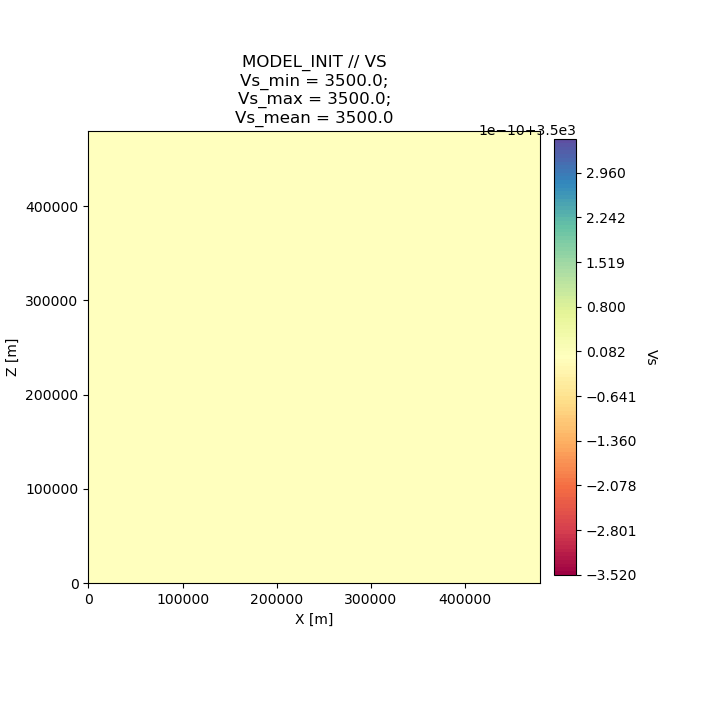

In [139]:
# We can use SeisFlows to plot images of the models to confirm
! seisflows plot2d MODEL_INIT vs --savefig m_init_vs.png
Image("m_init_vs.png")

Figure(707.107x707.107)


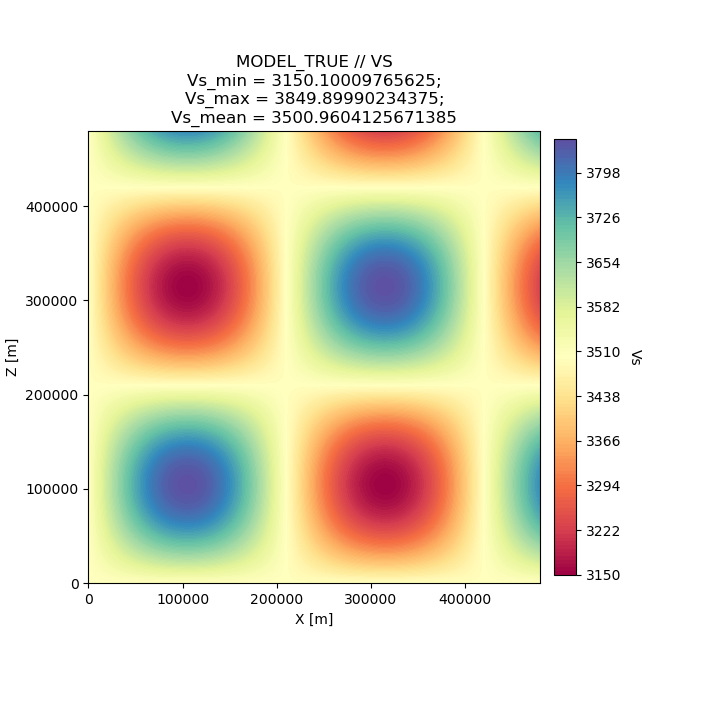

In [140]:
# Target Checkerboard model
! seisflows plot2d MODEL_TRUE vs --savefig m_true_vs.png
Image("m_true_vs.png")

Figure(707.107x707.107)


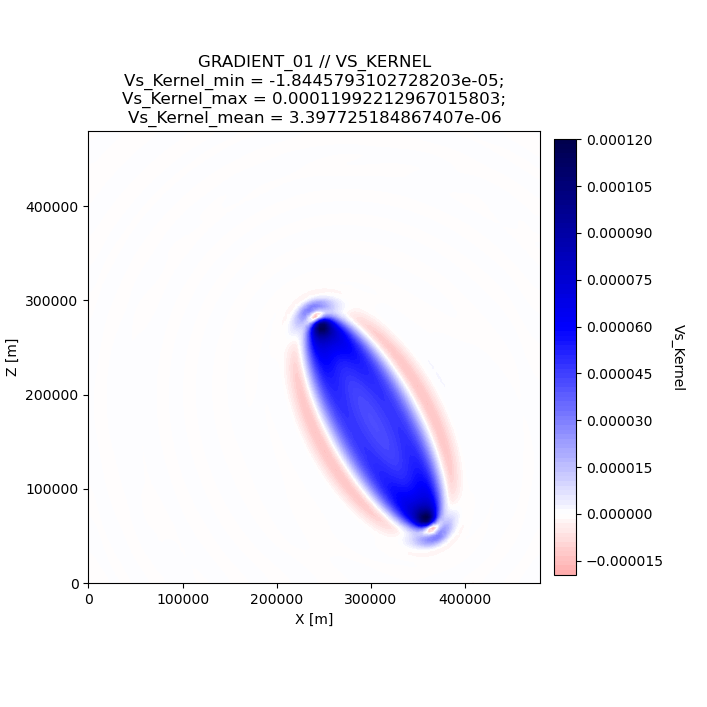

In [141]:
# Smoothed Vs kernel
! seisflows plot2d GRADIENT_01 vs_kernel --savefig g_01_vs.png
Image("g_01_vs.png")

#### Understanding SeisFlows outputs

- Model and kernel files are stored in the *output/* directory
- Within each solver directory we run an adjoint simulation (only one event in this case)
- Adjoint sources are tempomrarily stored in: `scratch/solver/*/traces/adj`
- Adjoint sources were created using a cross-correlation traveltime misfit (cc)
- The misfit kernel was smoothed with a 5km x 5km Gaussian


In [142]:
# Model and gradient files in the output/ directory
! ls output
! echo 
! ls output/MODEL_INIT/
! echo
! ls output/GRADIENT_01

GRADIENT_01  MODEL_INIT  MODEL_TRUE

proc000000_vp.bin  proc000000_vs.bin  proc000000_x.bin	proc000000_z.bin

proc000000_vp_kernel.bin  proc000000_vs_kernel.bin


In [143]:
# Solver directories and their adjoint traces
! ls scratch/solver/001
! echo
! ls scratch/solver/001/traces
! echo
! ls scratch/solver/001/traces/adj

adj_solver.log	combine_vs.log	fwd_solver.log	SEM	       traces
bin		DATA		kernel_paths	smooth_vp.log
combine_vp.log	fwd_mesher.log	OUTPUT_FILES	smooth_vs.log

adj  obs  syn

AA.S000000.BXY.adj


In [144]:
# SeisFlows parameters which controlled our adjoint simulation
! seisflows par adj_src_type  # Adjoint Source Type
! seisflows par smooth_h  # Horizontal Smoothing Length
! seisflows par smooth_v  # Vertical Smoothing Length

adj_src_type: cc
smooth_h: 5000.0
smooth_v: 5000.0
